# 简述

本文的目标是分析人口数据，并推测未来人口和供养率。

# 基本原理

人在出生后，就会不停死亡。每一年的人，能活到第二年的概率，有一个模型，叫[生命表](https://zh.wikipedia.org/wiki/%E7%94%9F%E5%91%BD%E8%A1%A8)。根据这个表，以及每年出生人口，你可以大致算出后续某年，几岁的人还有多少活着。

这个模型有几个问题。首先，生命表并不反应历史重大事件。例如，因为战争，饥荒，导致人口大量死亡。这个在生命表里是反应不出来的。其次，出生人口数据不是无限前推的。例如，你要算出今年100虽的人口有多少（假设生命表准确，上推的极限是105岁），就需要1924年的出生人口作为原始数据。这个原始数据我反正没有。所以，我们这个计算只能以其他方式进行拟合（或者叫凑合）。

这个凑合的最重要数据，就是每年总人口。每年出生数据是原始数据。用出生人口推算出来的每个年龄的人口数据，叫直接推断数据。用总人口减去直接推断数据，就得到剩余，这部分是间接数据。理论上说，如果有年龄分布数据的话，可以把剩余分布到各个年龄段。但是很可惜，这个修正对于刚开始的数据（在我这里是1949年前后）比较重要。可是我没有1949年的人口分布模型。到2024年的时候，1949年出生的人已经75了，分布模型也不重要了。所以我用了一个很土的办法——把剩余均摊到后面的年龄上去。

另一个参考数据，则是七普（或者你也可以用六普的数据附加校验）数据。七普是2020年，所以这张表算出来的2020年人口模型，应当符合2020年人口的年龄分布。

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib notebook
%matplotlib inline

# 原始人口数据

人口数据最权威的源头，来自国家统计局。[这个页面](https://data.stats.gov.cn/easyquery.htm?cn=C01)下方找“人口-总人口”，可以找到1949年之后的历年总人口数据。可惜的是，这张表并没有历年出生人口数据。我在[这里](https://zhuanlan.zhihu.com/p/634146715)找到了出生人口数据和总人口数据。经过核对，两者在总人口上一致。由此，我们得到了人口的基本原始数据。同时，我借鉴[这里](https://mlcldh.github.io/society/%E4%B8%AD%E5%9B%BD%E5%8E%86%E5%B9%B4%E5%87%BA%E7%94%9F%E4%BA%BA%E5%8F%A3.html)补充了49年和之前的一些出生数据。

注意，在统计局“人口-人口抽样调查样本数据”里面，可以找到按年龄分人口数据。但是这个数据经过我查验之后，和生命表模型有重大偏差。实话说我也不是很理解，为什么0-4岁人口占总人口的比例，和前5年新生人口统计出来的比例，两者偏差很大。我只能推测里面有一些我不知道的故事。但结论是，这个数据对我们的进一步分析用处不大。

In [2]:
population = pd.read_csv('population.csv', index_col='year')
population

,birth,total
year,,
1946,1009,NaN
1947,1122,NaN
1948,1139,NaN
1949,1275,54167.0
1950,2023,55196.0
...,...,...
2019,1465,141008.0
2020,1202,141212.0
2021,1062,141260.0


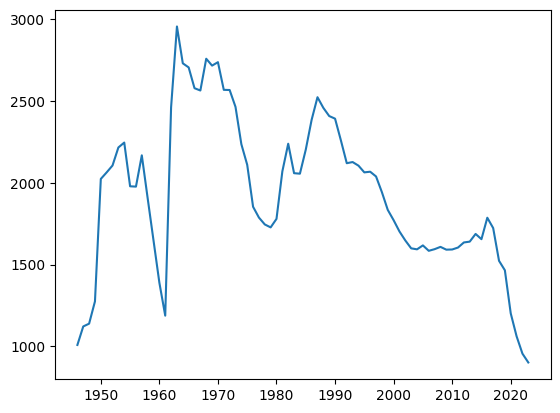

In [3]:
plt.plot(population['birth'])

# 生命表数据

你可以随便下一个差不多的生命表，我用的是[这张](https://www.cbirc.gov.cn/cn/view/pages/ItemDetail_gdsj.html?docId=19861&docType=2)。其中：

1. CL1（2010－2013）：非养老类业务一表（男）；
2. CL2（2010－2013）：非养老类业务一表（女）；
3. CL3（2010－2013）：非养老类业务二表（男）；
4. CL4（2010－2013）：非养老类业务二表（女）；
5. CL5（2010－2013）：养老类业务表（男）；
6. CL6（2010－2013）：养老类业务表（女）。

In [4]:
life = pd.read_csv('life.csv', index_col='age')
life

,CL1,CL2,CL3,CL4,CL5,CL6
age,,,,,,
0,0.000867,0.000620,0.000620,0.000455,0.000566,0.000453
1,0.000615,0.000456,0.000465,0.000324,0.000386,0.000289
2,0.000445,0.000337,0.000353,0.000236,0.000268,0.000184
3,0.000339,0.000256,0.000278,0.000180,0.000196,0.000124
4,0.000280,0.000203,0.000229,0.000149,0.000158,0.000095
...,...,...,...,...,...,...
101,0.476447,0.373856,0.397652,0.250172,0.354803,0.219242
102,0.506830,0.403221,0.426801,0.272831,0.382261,0.239737
103,0.537558,0.433833,0.456906,0.298551,0.410710,0.262537


# 计算直接推断数据

刚出生的人口，年底时算0岁。然后每年加一岁（去年0岁的今年1岁，下同），一直加到100。100这个数字有一定意义，下面会提到。

生命表里的每个数字，表示这个岁数的人，活到下一个岁数前死亡的概率。因此人口乘以1-生命表，就能得到明年下一个岁数的人口数量。这里我采用CL5数据作为下降参数，再扣除0.0014（即千分之1.4）。其中0.0014这个数据，是用来拟合七普的。具体往下看。

In [5]:
pop = population['birth'].copy()
population[0] = pop
for age in range(1, 100):
    pop.index += 1
    pop *= (1-life['CL5'][age-1]-0.0014)
    population[age] = pop.copy()
    population = population.copy()
population

,birth,total,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
year,,,,,,,,,,,,,,,,,,,,,
1946,1009,NaN,1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947,1122,NaN,1122,1007.016306,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1948,1139,NaN,1139,1119.794148,1005.217775,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,1275,54167.0,1275,1136.760726,1117.794196,1003.541072,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,2023,55196.0,2023,1272.493350,1134.730471,1115.929715,1001.939420,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,1465,141008.0,1465,1520.005782,1716.541354,1776.337318,1643.418970,1672.585092,1623.481048,1616.051820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,1202,141212.0,1202,1462.119810,1517.291052,1713.678163,1773.502284,1640.858523,1670.007639,1620.993875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,1062,141260.0,1062,1199.636868,1459.508464,1514.760210,1710.943133,1770.739167,1638.329960,1667.449187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 计算间接推断数据

In [6]:
rest = population['total'].copy()
for age in range(0, 100):
    rest -= population[age].fillna(0)
population['rest'] = rest
population = population.copy()

population = population.drop([1946, 1947, 1948])
for i, s in population.iterrows():
    avg = s['rest']/s.isna().sum()
    population.loc[i] = s.fillna(avg)
population = population.drop(['birth', 'total', 'rest'], axis=1)
population

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
year,,,,,,,,,,,,,,,,,,,,,
1949,1275,1136.760726,1117.794196,1003.541072,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,...,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833
1950,2023,1272.493350,1134.730471,1115.929715,1001.939420,512.083232,512.083232,512.083232,512.083232,512.083232,...,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232
1951,2063,2019.022782,1270.220677,1132.837741,1114.148691,1000.378398,507.450976,507.450976,507.450976,507.450976,...,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976
1952,2105,2058.944142,2015.416807,1268.101949,1131.029732,1112.412847,998.836815,503.142556,503.142556,503.142556,...,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556
1953,2215,2100.861570,2055.266868,2012.055092,1266.078058,1129.267588,1110.698619,997.306597,499.015931,499.015931,...,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,1465,1520.005782,1716.541354,1776.337318,1643.418970,1672.585092,1623.481048,1616.051820,1582.986989,1568.738772,...,218.897535,218.897535,218.897535,218.897535,218.897535,218.897535,218.897535,218.897535,218.897535,218.897535
2020,1202,1462.119810,1517.291052,1713.678163,1773.502284,1640.858523,1670.007639,1620.993875,1613.580877,1580.563436,...,206.603141,206.603141,206.603141,206.603141,206.603141,206.603141,206.603141,206.603141,206.603141,206.603141
2021,1062,1199.636868,1459.508464,1514.760210,1710.943133,1770.739167,1638.329960,1667.449187,1618.515375,1611.110485,...,193.642435,193.642435,193.642435,193.642435,193.642435,193.642435,193.642435,193.642435,193.642435,193.642435


# 拟合七普数据

所谓拟合[七普数据](http://montreal.china-consulate.gov.cn/zgyw/202105/t20210514_9014068.htm)，我们主要是拟合年龄数据。即计算0-14，15-59，60以上，65以上的人口数据，和七普数据交叉验证。

In [7]:
pop20 = population.loc[2020].fillna(0)
# pop of 60-99 = 26401
print(pop20[60:100].sum())
# pop of 65-99 = 19063
print(pop20[65:100].sum())
# pop of 15-59 = 89437
print(pop20[15:60].sum())
# pop of 0-14 = 25338
print(pop20[0:15].sum())

26782.432745867867
19014.23549002746
90818.8496460739
23610.717608058218


这四个数字，在我取上文参数0.0014的时候，误差最小。当然，你也可以用CL1/CL3，再加修正。我算出来CL1的修正参数是0.0009。中国人每个年龄的实际死亡几率，要比生命表里的大一些。大家可以细品一下。

# 计算出生率

我们可以取N岁到M岁作为育龄人口，计算新生儿对其比率。定义上女性育龄是15-49，我觉得这个定义太丧心病狂了点，所以采用的是20-40。你可以很容易的算出来育龄生育率图。大致是一张百分比曲线。但是请注意，这个图有意义的部分在1989年之后。因为，还记得么？之前的人口-年龄分布都是我们瞎填的，中年人太少，老年人太多，所以算出来的比率一定高得惊人。截取有意义的部分后，得到的图是从0.06一路下滑到0.02。这个数值的实际意义是，2023年，100对育龄夫妇（假设全结婚了）每年生育4个孩子。换算成总和生育率就是0.8。1986年的数据0.06对应的总和生育率就是2.4。

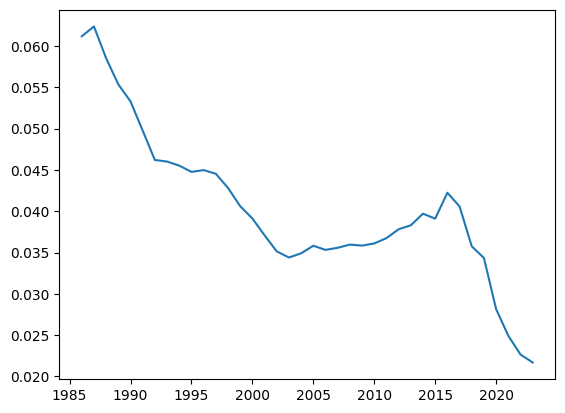

In [8]:
s = population.loc[:, 0]/population.loc[:, 20:40].sum(axis=1)
plt.plot(s[s.index>1985])

# 外推出生数据

假设总和生育率维持0.8不变，我们可以推算出接下去35年的人口数据。

In [9]:
for y in range(2023, 2060):
    pop = population.loc[y]
    pop *= (1-life['CL5']-0.0014)
    pop.index += 1
    pop = pop.copy()
    pop.loc[0] = 0.02*population.loc[y, 20:40].sum()
    population.loc[y+1] = pop
population

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
year,,,,,,,,,,,,,,,,,,,,,
1949,1275.000000,1136.760726,1117.794196,1003.541072,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,...,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833,517.019833
1950,2023.000000,1272.493350,1134.730471,1115.929715,1001.939420,512.083232,512.083232,512.083232,512.083232,512.083232,...,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232,512.083232
1951,2063.000000,2019.022782,1270.220677,1132.837741,1114.148691,1000.378398,507.450976,507.450976,507.450976,507.450976,...,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976,507.450976
1952,2105.000000,2058.944142,2015.416807,1268.101949,1131.029732,1112.412847,998.836815,503.142556,503.142556,503.142556,...,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556,503.142556
1953,2215.000000,2100.861570,2055.266868,2012.055092,1266.078058,1129.267588,1110.698619,997.306597,499.015931,499.015931,...,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931,499.015931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,406.226079,424.181707,441.147251,457.870492,473.801810,489.221584,504.314491,519.390984,533.859664,547.836242,...,694.539203,629.458406,540.232875,488.787924,333.792784,129.410474,118.638935,107.469079,92.285734,75.539581
2057,387.903725,405.427438,423.424118,440.411417,457.139731,473.063626,488.467694,503.541881,518.596835,533.042325,...,690.765998,599.894346,535.283875,451.557971,400.822717,267.971183,101.470882,90.634215,79.787194,66.406507
2058,367.078755,387.141106,404.703345,422.717847,439.708520,456.427507,472.334635,487.719361,502.771966,517.802864,...,743.051837,596.635316,510.142953,447.421309,370.292889,321.783283,210.116473,77.518680,67.288654,57.412870


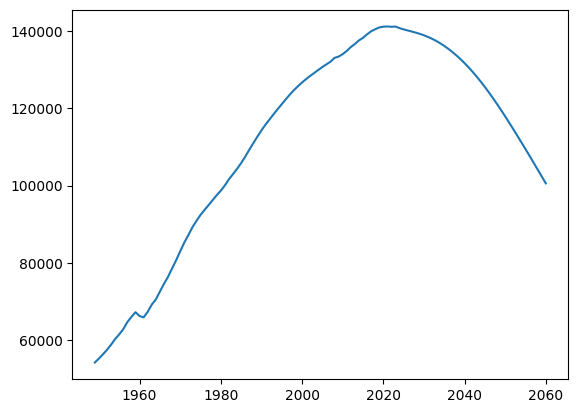

In [10]:
total = population.sum(axis=1)
plt.plot(total)

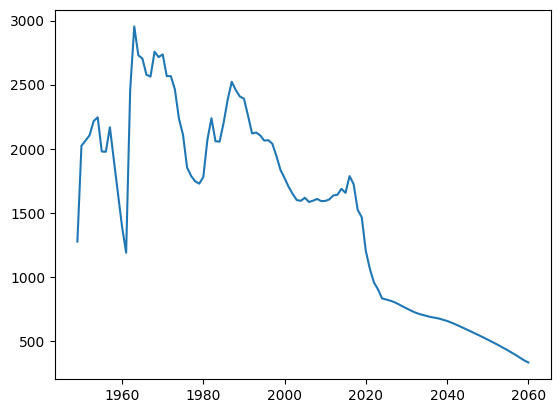

In [11]:
birth = population[0]
plt.plot(birth)

# 计算劳动力人口

劳动力采用的是近似计算。20-50岁百分百是劳动力，50-60有一半是劳动力。实际上由于男女性别比例并不是1:1，而且还有女干部退休时间为55岁。因此真实的劳动力数据会比我们算出来的高一些。

该数据第一个有意义的数据，出现在2009年。此时1949年出生的人已经（理论上）全部退休）。我们不再受49年之前数据缺失的干扰。但是数据显示，这个有意义的数据出现后，劳动力人口即大幅回落。从趋势上也能看出，尽管数据并不精确，但劳动力人口在2010-2020间达峰的结论不变。

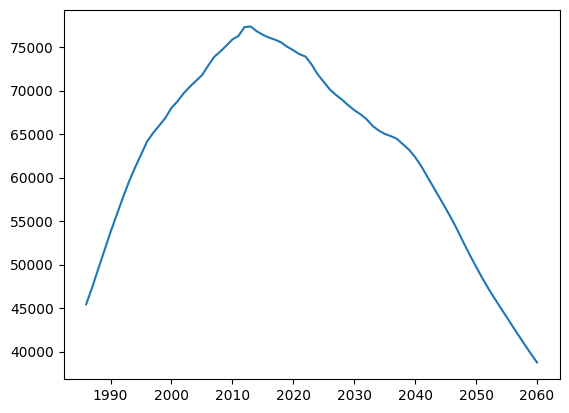

In [12]:
labors = population.loc[:, 20:50].sum(axis=1)+0.5*population.loc[:, 50:60].sum(axis=1)
plt.plot(labors[labors.index>1985])

# 计算退休人口

退休人口同样采用近似计算，50-60间一半是退休人口。

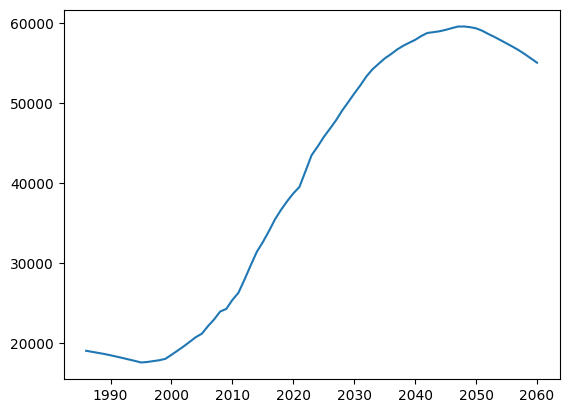

In [13]:
retired = population.loc[:, 60:].sum(axis=1)+0.5*population.loc[:, 50:60].sum(axis=1)
plt.plot(retired[retired.index>1985])

# 计算退休供养率

所谓劳动供养率，指劳动人口占总人口的比例。而退休供养率，指退休人口和劳动人口的比例。这个值近似可以理解为“一个劳动人口供养几个退休人口”。

In [14]:
support_ratio = retired/labors
support_ratio[2024]

np.float64(0.6202988003295761)

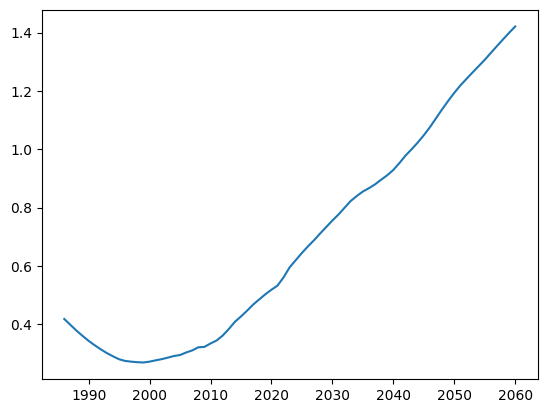

In [15]:
plt.plot(support_ratio[support_ratio.index>1985])

# 如果维持退休供养率基本保持在2024年水平，需要延迟到几岁退休

In [16]:
l = []
for f in range(55, 63):
    for m in range(60, 70):
        labors = population.loc[2050, 20:f].sum()+0.5*population.loc[2050, f:m].sum()
        retired = population.loc[2050, m:].sum()+0.5*population.loc[2050, f:m].sum()
        l.append([f, m, labors, retired, retired/labors])

df = pd.DataFrame(l, columns=['F', 'M', 'labors', 'retired', 'support_ratio'])
df = df[df.support_ratio < 0.65]
df = df.set_index(['F', 'M'])
df

labors       retired  support_ratio
F  M                                            
59 69  66721.630764  42371.868918       0.635054
60 68  66975.898663  42377.096966       0.632722
   69  67810.557750  41387.023523       0.610333
61 66  66254.447990  42982.347268       0.648747
   67  67101.644620  42122.237771       0.627738
   68  68014.010885  41340.210776       0.607819
   69  68848.669972  40350.137333       0.586070
62 65  66467.769681  42936.104695       0.645969
   66  67321.422745  41944.848062       0.623053
   67  68168.619375  41084.738565       0.602693
   68  69080.985640  40302.711570       0.583413
   69  69915.644726  39312.638126       0.562287